# Exploratory Demo of Epistatic Site Methods


*Goal:* infer prevalence of sets of redundant sites, where all sites within a set must be eliminated to observe a fitness effect.
Differentiate these sites from sites with additive individual effects.

**Outline:**
- Generate sample genome and check ground-truth counts of different site types
- Sample repeat skeletonizations of sample genome (i.e., knockouts where no remaining sites can be removed without observing a fitness effect)
- Visualize distribution of skeletonization outcomes site-by-site,
    - how often does a particular site appear in skeletons?
- For sampled skeletons, perform "jackknife" knockouts where each site remaining within skeleton is removed and the fitness effect is measured.
- Use "jackknife" knockout severity to differentiate epistatic sites from additive sites; in particular, redundant sites will
    1. have high severity jackknife knockout outcomes AND
    2. be excluded from many skeletons (i.e., depending on whether it is last member of set remaining within the skeleton).


## Preliminaries


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import outset as otst
from outset import patched as otst_patched
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib.analyze_epistasis import (
    assay_epistasis_naive,
    describe_skeletons,
    skeletonize_naive,
)
from pylib.auxlib._jitter import jitter
from pylib.modelsys_explicit import GenomeExplicit
from pylib.modelsys_explicit import (
    GenomeExplicit,
    CalcKnockoutEffectsAdditive,
    CalcKnockoutEffectsEpistasis,
    create_additive_array,
    create_epistasis_matrix_overlapping,
    describe_additive_array,
    describe_epistasis_matrix,
)


Method implementations are organized as external Python source files within the local `pylib` directory.


In [2]:
np.random.seed(1234)


Ensure reproducibility.


## Create Sample Genome


Create a genome with 4,000 distinct sites.

Let 5% of sites have an additive knockout fitness effect below detectability threshold (uniform between 0 and 0.7 fitness effect).

Assign 20 sets of epistatic effects, with 5 sites per set.
Apply a set-specific fitness penalty between 0.7 and 1.6 when all sites in a set are knocked out.

Fitness 1.0 is considered the threshold for detectability.


In [3]:
num_sites = 4000
distn = lambda x: np.random.rand(x) * 0.7  # mean effect size of 0.7 / 2
additive_array = create_additive_array(num_sites, 0.05, distn)
epistasis_matrix = create_epistasis_matrix_overlapping(num_sites, 20, 5)
genome = GenomeExplicit(
    [
        CalcKnockoutEffectsAdditive(additive_array),
        CalcKnockoutEffectsEpistasis(epistasis_matrix, effect_size=(0.7, 1.6)),
    ],
)


## Describe and Inspect Genome


Tabulate description of content of each genome site.


In [4]:
dfa = describe_additive_array(additive_array)
dfb = describe_epistasis_matrix(epistasis_matrix)
df_genome = pd.DataFrame.merge(dfa, dfb, on="site")
df_genome["site type"] = (
    df_genome["additive site"].astype(int)
    + df_genome["epistasis site"].astype(int) * 2
).map(
    {
        0: "neutral",
        1: "additive",
        2: "epistasis",
        3: "both",
    }
)

df_genome


,site,additive site,additive effect,epistasis site,num epistasis effects,site type
0,0,False,0.000000,False,0,neutral
1,1,False,0.000000,False,0,neutral
2,2,False,0.000000,False,0,neutral
3,3,False,0.000000,False,0,neutral
4,4,False,0.000000,False,0,neutral
...,...,...,...,...,...,...
3995,3995,True,0.059342,False,0,additive
3996,3996,False,0.000000,True,1,epistasis
3997,3997,False,0.000000,False,0,neutral
3998,3998,False,0.000000,False,0,neutral


How many of each kind of site are in the genome?


neutral      3706
additive      195
epistasis      94
both            5
Name: site type, dtype: int64
non-neutral 294


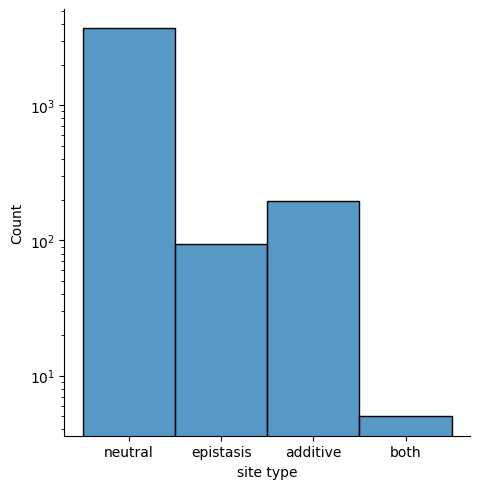

In [5]:
sns.displot(df_genome["site type"])
plt.yscale("log")
print(df_genome["site type"].value_counts())
print("non-neutral", (df_genome["site type"] != "neutral").sum())


## Perform Skeletonizations


"Skeletons" are minimal sets of genome sites that maintain wile-type fitness.
Skeletons can be generated by sequentially removing sites from the genome, until no further sites can be removed without detectably reducing fitness.

Sample 20 skeletons.


In [6]:
num_skeletonizations = 20
skeletons = np.vstack(
    [
        skeletonize_naive(num_sites, genome.test_knockout)
        for _ in tqdm(range(num_skeletonizations))
    ],
)


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Here's an example skeleton.


array([False, False, False, ..., False, False, False])

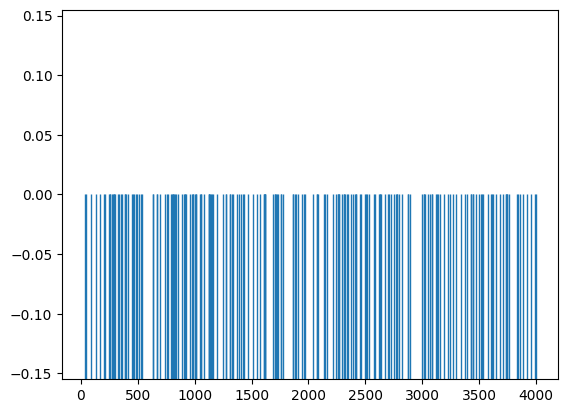

In [7]:
# convert from knockout true to retained true
retained_sites = ~skeletons[0].astype(bool)
sns.rugplot(
    np.flatnonzero(retained_sites),
    height=0.5,
)
retained_sites


## Describe Skeletons


Plot frequency that sites are excluded from skeletons (y axis) and the number of steps into the skeletonization process when sites are excluded (x axis).
(Sites are considered for knockout in random order, but some appear to only be knocked out neutrally early on.)

Sites that can be knocked out neutrally late in the skeletonization process appear to be successfully excluded from skeletons more often.


First, excluding neutral sites.


<AxesSubplot: xlabel='skeleton exclusion order', ylabel='skeleton exclusion frequency'>

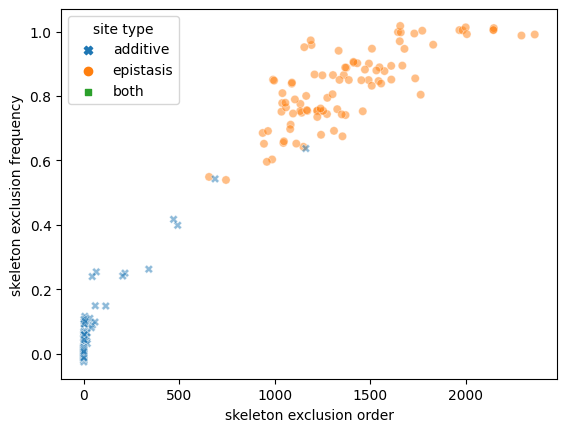

In [8]:
otst_patched.scatterplot(
    pd.DataFrame(
        {
            "skeleton exclusion order": np.mean(skeletons, axis=0),
            "skeleton exclusion frequency": jitter(
                np.mean(skeletons.astype(bool), axis=0),
                amount=0.01,
            ),
            "site type": df_genome["site type"],
        },
    ),
    x="skeleton exclusion order",
    y="skeleton exclusion frequency",
    hue="site type",
    style="site type",
    hue_order=["additive", "epistasis", "both"],
    alpha=0.5,
)


Same plot, but including neutral sites.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


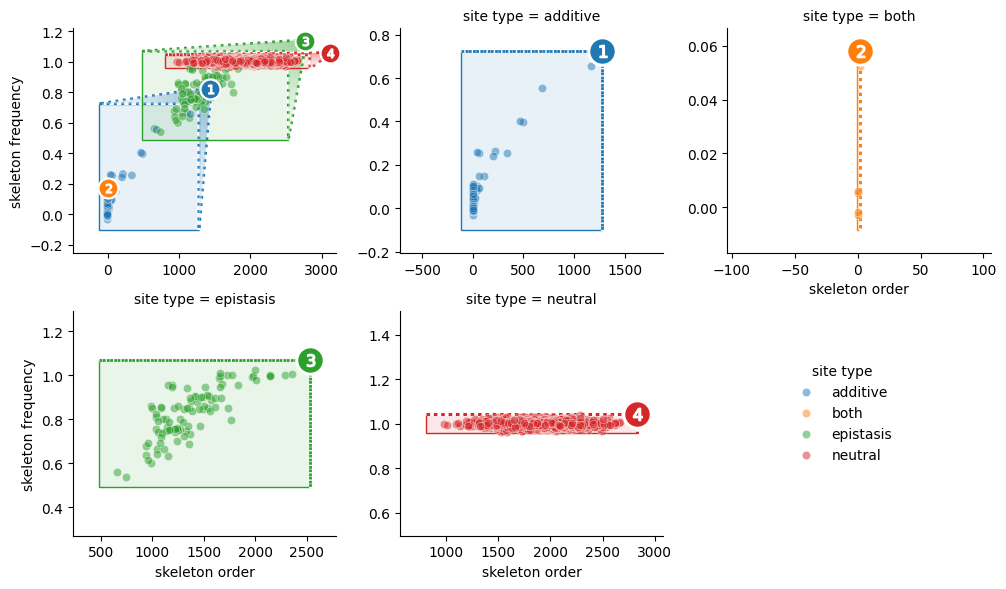

In [9]:
assert (np.diff(df_genome["site"]) == 1).all()  # is sorted?
og = otst.OutsetGrid(
    data=pd.DataFrame(
        {
            "skeleton order": np.mean(skeletons, axis=0),
            "skeleton frequency": jitter(
                np.mean(skeletons.astype(bool), axis=0),
                amount=0.01,
            ),
            "site type": df_genome["site type"],
        },
    ),
    x="skeleton order",
    y="skeleton frequency",
    hue="site type",
    col="site type",
    col_wrap=3,
)
og.map_dataframe(
    sns.scatterplot,
    x="skeleton order",
    y="skeleton frequency",
    alpha=0.5,
    legend=False,
)
og.add_legend(loc="lower right", bbox_to_anchor=(0.9, 0.2))
og.marqueeplot()

plt.show()


How many unique sites are included in at least one skeleton?
(i.e., num sites with direct evidence of functionality)


In [10]:
np.any(
    (~skeletons.astype(bool)),
    axis=0,
).sum()


280

## Perform Jackknife Knockouts


For each skeleton, knock out each site retained one-by-one, and measure severity of fitness effect.
Then, tabulate jackknife knockout outcomes on a per-site basis.


In [11]:
df_skeletons = describe_skeletons(skeletons, genome.test_knockout)

df_skeletons


,site,"skeleton dose, excluded","skeleton dose std, excluded","skeleton dose ptp, excluded","skeleton exclusion order, excluded","skeleton exclusion order std, excluded","skeleton exclusion order ptp, excluded","skeleton outcome count, excluded","skeleton outcome frequency, excluded","skeleton dose, included",...,"skeleton outcome frequency, included",jackknife dose,jackknife dose std,jackknife dose ptp,raw jackknife result,raw jackknife result std,raw jackknife result ptp,jackknife result,jackknife result std,jackknife result ptp
0,0,3790.85,2.058998,8.0,2495.40,1166.566415,3450.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3790.85,2.058998,8.0,2203.35,1032.936910,3308.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3790.85,2.058998,8.0,1885.65,919.093391,2855.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3790.85,2.058998,8.0,1574.10,1185.745730,3392.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3790.85,2.058998,8.0,1585.80,1099.778571,3202.0,20,1.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3857,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3790.85,...,1.0,3791.85,2.058998,8.0,1.196941,0.003279,0.014553,1.196941,0.003279,0.014553
3996,3890,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3790.85,...,1.0,3791.85,2.058998,8.0,1.678550,0.003279,0.014553,1.678550,0.003279,0.014553
3997,3918,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3790.85,...,1.0,3791.85,2.058998,8.0,1.420299,0.003279,0.014553,1.420299,0.003279,0.014553
3998,3960,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3790.85,...,1.0,3791.85,2.058998,8.0,1.465860,0.003279,0.014553,1.465860,0.003279,0.014553


## Use Skeleton Jackknifes to Differentiate Epistasis versus Additive Sites


Our goal is to isolate epistatic sites and then count them up.

Do this by setting thresholds for skeleton exclusion frequency and jackknife knockout severity, then counting sites that exceed both thresholds.

First, set the skeleton exclusion frequency threshold at 0.3.
Then, look at all points excluded *less* than 30% of the time.
Take the 20th percentile of these sites' jackknife knockout severities.
This is the jackknife knockout severity threshold.

Then, count sites that exceed both thresholds.


In [12]:
est = assay_epistasis_naive(
    df_skeletons,
    exclusion_frequency_thresh=0.3,
    jackknife_severity_thresh=0.2,
)
est


{'num epistasis sites estimate': 80,
 'exclusion frequency cutoff': 0.3,
 'jackknife severity cutoff': 1.1739066427089908}

For comparison, the actual count of epistasis sites is


In [13]:
df_genome["site type"].value_counts()["epistasis"]


94

This estimate could probably be improved with mark-recapture methods as used in the "agnostic" methods.


Visualization of process used to discern epistatic sites from small-effect sites.
Sites within shaded region are counted as epistatic.


teeplots/hue=site-type+style=site-type+viz=scatterplot-rect+x=skeleton-exclusion-rate+y=jackknife-knockout-severity+ext=.pdf
teeplots/hue=site-type+style=site-type+viz=scatterplot-rect+x=skeleton-exclusion-rate+y=jackknife-knockout-severity+ext=.png


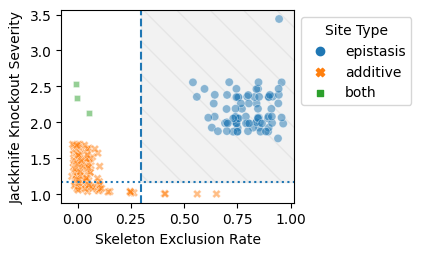

<AxesSubplot: xlabel='Skeleton Exclusion Rate', ylabel='Jackknife Knockout Severity'>

In [14]:
df_joint = pd.DataFrame.merge(  # combine genome & skeleton data
    df_genome,
    df_skeletons,
    on="site",
)
def scatterplot_rect(*args, **kwargs) -> plt.Axes:
    ax = sns.scatterplot(
        **kwargs,
        alpha=0.5,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axvline(est["exclusion frequency cutoff"], ls="--")
    plt.axhline(est["jackknife severity cutoff"], ls=":")
    with plt.rc_context({"hatch.color": "lightblue"}):
        plt.gca().add_patch(
            plt.Rectangle(
                (
                    est["exclusion frequency cutoff"],
                    est["jackknife severity cutoff"],
                ),
                plt.xlim()[1] - est["exclusion frequency cutoff"],
                plt.ylim()[1] - est["jackknife severity cutoff"],
                alpha=0.05,
                fill=True,
                hatch="\\",
                zorder=-1,
                color="black",
            ),
        )
    plt.gcf().set_size_inches((3, 2.5))
    return ax

tp.tee(
    scatterplot_rect,
    data={
        "Skeleton Exclusion Rate": jitter(
            df_joint["skeleton outcome frequency, excluded"],
            amount=0.01,
        ),
        "Jackknife Knockout Severity": df_joint["jackknife result"],
        "Site Type": df_joint["site type"].replace("neutral", np.nan),
    },
    x="Skeleton Exclusion Rate",
    y="Jackknife Knockout Severity",
    hue="Site Type",
    style="Site Type",
)


Note the presence of *very* small-effect additive sites (i.e., low jackknife knockout severity) with high exclusion rates.
This is why we need jackknife severity to identify epistatic sites.
